In [335]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import math
import utils
import seaborn as sns
import pandas as pd

%matplotlib inline

## Bayesian Linear Regression

In the following noteboom we'll be reviewing the basic concepts to implement a bayesian linear regression from scratch. For the case we will use the following notation: 

1. The symbol $\mathbf{x}$ makes reference to the input data (For the case one dimensional)
2. The symbol $\mathbf{\Phi}$ makes reference to the design matrix
3. The symbol $y$ is the true value of the function without noise
4. The symbol $t$ is the output of the function with noise

### Linear Regression The model:

For the case we are assuming that the linear regression model can be defined as the linear combination of parameters in the following way:

$$y(\mathbf{w}, \mathbf{x}) = \mathbf{w}^T \mathbf{\phi}(\mathbf{x})$$

Where $\mathbf{\phi}$ corresponds to a nonlinear transformation of the input $\mathbf{x}$. Also here we assumed that the model is noise free. However in reality we can assume that the data that we use to train the model comes with some noise, so the actual model has the following notation:

$$y = y(\mathbf{w}, \mathbf{x}) + \epsilon$$


Where $\epsilon \sim \mathcal{N}(t | y(\mathbf{w}, \mathbf{x}), \beta^{-1})$. We will see later why this formulation makes sense. After this formulation there are standard and wide known techniques to solve that problem, One is MLE, Regularized Regression, MAP (Maximum a Posteriori), etc... .

### Input data: Noise Free and Noisy

0.00824350428048164


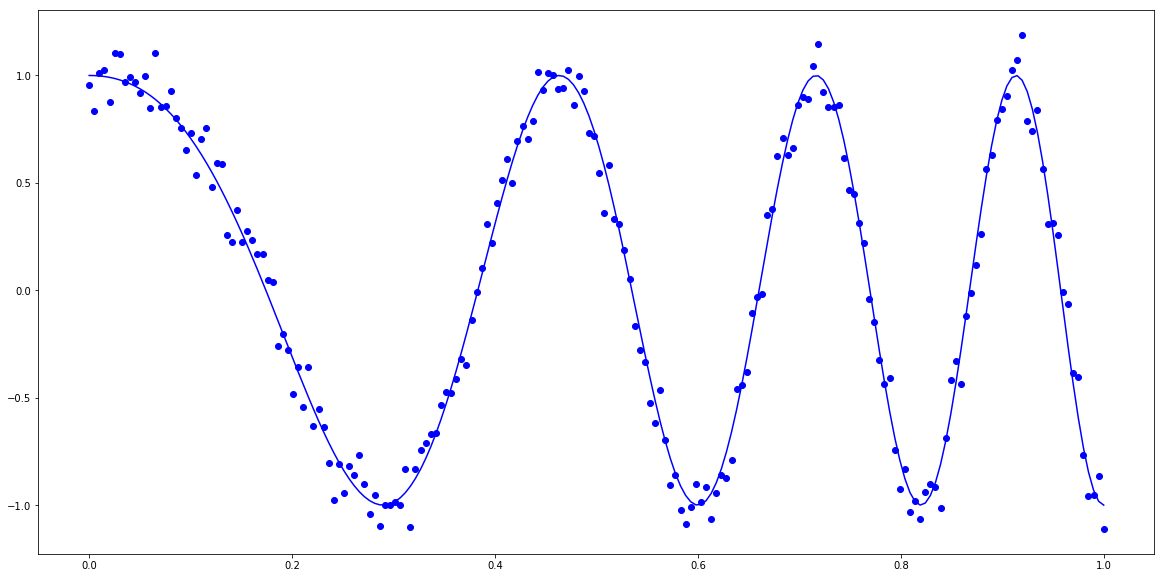

In [397]:
mdata = scipy.io.loadmat('ejemplo_regresion.mat')
x = np.array(mdata['x'])
y = np.array(mdata['y'])
t = np.array(mdata['t'])
N = len(x)
mdiff = (t - y)*(t - y)
mvar = (np.sum(mdiff))/N
print(mvar)
plt.figure(1, figsize=(20,10))
plt.plot(x, y, 'b', x, t, 'bo')

### Util Functions: Bayesian Posterior, MLE 2, input transformation

#### Input Data  Transformation
In our Linear regression Model we can have a polynomial transformation of our inputs or also we can have another transformations such as exponential or tanh. We are transforming our inputs to add some non linearity. So the following routine will return something like this:

$$
\Phi
=
\begin{bmatrix}
    \phi_0(\mathbf{x}_{1}) &\phi_1(\mathbf{x}_{1}) & \phi_2(\mathbf{x}_{1}) & \dots  & \phi_{M-1}(\mathbf{x}_{1}) \\
    \phi_0(\mathbf{x}_{2}) &\phi_1(\mathbf{x}_{2}) & \phi_2(\mathbf{x}_{2}) & \dots  & \phi_{M-1}(\mathbf{x}_{2}) \\
    \vdots                 & \vdots                & \vdots & \ddots & \vdots \\
    \phi_0(\mathbf{x}_{N}) &\phi_1(\mathbf{x}_{N}) & \phi_2(\mathbf{x}_{N}) & \dots  & \phi_{M-1}(\mathbf{x}_{N})
\end{bmatrix}
\
\
$$

So each row of this matrix represents a data point in a new space ${\rm I\!R}^M$

In [ ]:
# Evaluation of design matrix -----------------------------------------------------
def basis_functions_eval(xx, MM, op = 'poly'):
    "This function does a nonlinear transformation of input data"
    PHI = np.zeros((len(xx),MM))
    #print PHI
    PHI[:,0] = np.ones(len(xx))
    mu = np.linspace(0.0, 1.0, MM - 1)
    aux = np.diff(mu)
    s2 = 0.2*aux[0]
    xx.shape = (len(xx))
    #print xx.shape, PHI[:,1].shape
    for i in range(1, MM):
        if(op == 'poly'):
            PHI[:, i] = (xx**i)
        elif(op == 'exp'):
            PHI[:,i] = np.exp(-((xx - mu[i - 1])**2.0)/(2.0*s2))
        elif(op == 'tanh'):
            PHI[:, i] = 1.0/(1.0 + np.exp(-(xx - mu[i - 1])/(math.sqrt(s2))))
    return PHI

#### Posterior distribution (Over parameters) Computation (Training step)

This is probably one of the most important steps in all the bayesian approach. So Basiccally in teh bayesian framework instead of finding only a solution for $\mathbf{w}$ we find a probability distribution over the parameters using the bayes theorem, so the formulation is:

$$ p(\mathbf{w} | \mathcal{D}) = \frac{p(\mathcal{D} | \mathbf{w}) p(\mathbf{w})}{p(\mathcal{D})}$$

Where:
1. $p(\mathbf{w} | \mathcal{D})$ is the posterior, Our objective. The probability distributon after observing data.
2. $p(\mathcal{D} | \mathbf{w})$ The model likelihood, How likely is the training data given the parameters.
3. $p(\mathbf{w})$ is the prior. Basically here we codify our previous knowledge about the distirbution over the parameters.
4. $p(\mathcal{D})$ evidence.

In [ ]:
# Bayes estimation -----------------------------------------------------
def bayes_lin_estim(PHI, tt, alpha, beta, mn_ant, sn_ant):
    PHI = np.matrix(PHI)
    sn_ant = np.matrix(sn_ant)
    mn_ant = np.matrix(mn_ant)

    PHIt = np.transpose(PHI)
    tt = np.matrix(tt)
    Sn_inv = (np.linalg.inv(sn_ant)) + (beta*PHIt*PHI)
    Sn = np.linalg.inv(Sn_inv)*np.eye(PHI.shape[1])
    mn = Sn*(np.linalg.inv(sn_ant)*mn_ant + (beta*PHIt*tt))
        
    #print mn
    #print Sn
    return mn, Sn

#### Hyperparameters estimation
In order to 

In [289]:
def maxim_likelihood_2(PHI, tt, niters = 20):
    # iterative method for finding alpha and beta. Initial values set empirically
    alpha = 0.0000000000000003
    beta = 0.09079
    PHI = np.matrix(PHI)
    PHIt = np.transpose(PHI)
    tt = np.matrix(tt)
    rho,v = np.linalg.eig(PHIt*PHI)
    lambda_par = beta*rho

    alpha_arr = np.ones((niters + 1, 1))
    beta_arr = np.ones((niters + 1, 1))
    beta_arr[0] = beta
    alpha_arr[0] = alpha

    for i in range(1, niters + 1):
        A = alpha*np.eye(PHI.shape[1]) +  beta*(PHIt*PHI)
        Ainv = np.linalg.inv(A)*np.eye(PHI.shape[1])
        mn = beta*Ainv*PHIt*tt
        mnt = np.transpose(mn)
        gamma = np.sum(lambda_par/(lambda_par + alpha))
        alpha = float((gamma/(mnt*mn)))
        aux = (tt - PHI*mn);
        betaInv = (float(np.transpose(aux)*aux))/(PHI.shape[0] - gamma)
        beta = 1.0/betaInv
        lambda_par = beta*rho
        beta_arr[i] = beta
        alpha_arr[i] = alpha

    #alpha = 0.000000000003
    #beta = 0.09079
    return alpha,beta

### Visualizing the prior over some of the parameters

(10,) (10, 10)


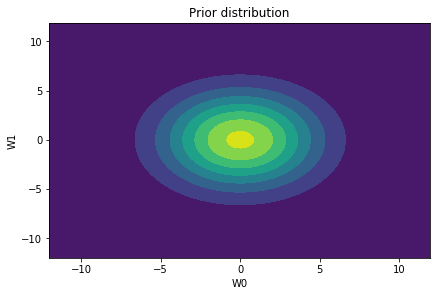

In [309]:
# computing design matrix
basis_functions = 10
PHI_training = basis_functions_eval(x, basis_functions, op = 'poly')
alpha = np.sqrt(mvar)
beta = 0.01

# Prior definition
prior_mean = np.zeros(basis_functions)
prior_cov = (1 / alpha) * np.eye(basis_functions)
print(prior_mean.shape, prior_cov.shape)

def get_values_draw(prior_mean, prior_cov):
    from scipy.stats import multivariate_normal
    xx, yy = np.mgrid[-12:12:.1, -12:12:.1]
    pos = np.empty(xx.shape + (2,))
    pos[:, :, 0] = xx; pos[:, :, 1] = yy
    rv = multivariate_normal(prior_mean[0:2], prior_cov[0:2,0:2])
    
    return xx, yy, rv.pdf(pos)

fig1, ax2 = plt.subplots(constrained_layout=True)
ax2.set_title('Prior distribution')
ax2.set_xlabel('W0')
ax2.set_ylabel('W1')
xx, yy, zz = get_values_draw(prior_mean, prior_cov)
ax2.contourf(xx, yy , zz)

### Computing the posterior iteratively

In [310]:
# Choosing some random points
#np.random.seed(2)
random_indexes = np.random.permutation(PHI_training.shape[0])
random_indexes = random_indexes.reshape((10,20))

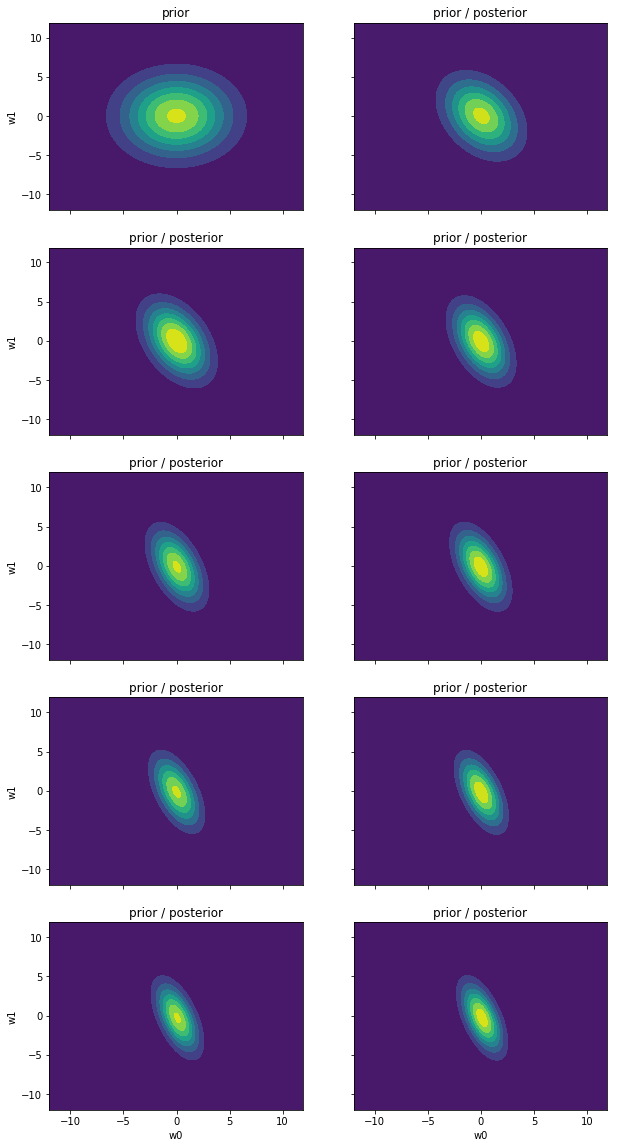

In [311]:
# Prior definition
prior_mean = np.zeros(basis_functions)
prior_cov = (1 / alpha) * np.eye(basis_functions)
f, axarr = plt.subplots(5, 2)
f.set_figwidth(10)
f.set_figheight(20)
count_fig = 1
for idx in random_indexes:
    xx, yy, zz = get_values_draw(prior_mean, prior_cov)
    axarr[(count_fig - 1) // 2, (count_fig - 1) % 2].contourf(xx, yy , zz)
    axarr[(count_fig - 1) // 2, (count_fig - 1) % 2].set_title('prior / posterior' if count_fig != 1 else 'prior')
    count_fig += 1
    PHI_current = PHI_training[idx, :]
    t_current = t[idx]
    prior_mean = np.matrix(prior_mean).T
    prior_mean, prior_cov = bayes_lin_estim(PHI_current, t_current, alpha, beta, prior_mean, prior_cov)
    #prior_mean, prior_cov = np.copy(mn_current), np.copy(Sn_current)
    prior_mean = np.asarray(prior_mean).reshape((prior_mean.shape[0],))

for ax in axarr.flat:
    ax.set(xlabel='w0', ylabel='w1')
for ax in axarr.flat:
    ax.label_outer()

So far we have just computed the Posterior distribution for $W$. The mean of the posterior is known as the Maximum a Posteriori Solution. That is the value in which the posterior is maximum, given that we had a prior. You can use this solution as the parameters you finally use to make your predictions, however this will not be full Bayesian.

In order for your solution to be full bayesian we should condition the value of our prediction on unseen data against our "knowledge" over the training data.

#### prediction for unseen data

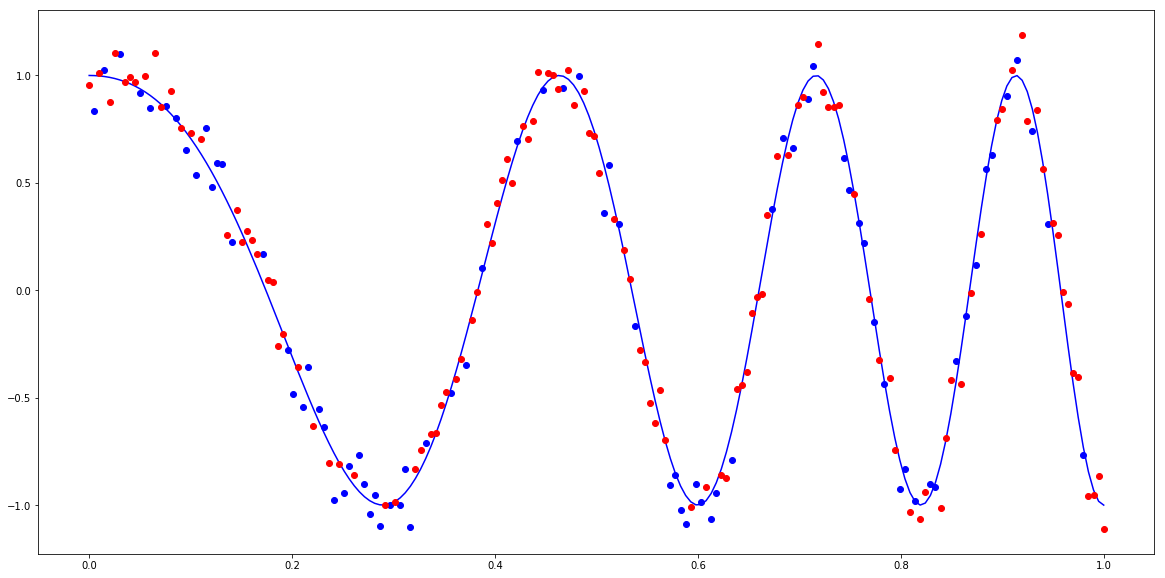

In [434]:
np.random.seed(5)
N_train = 80
random_indexes = np.random.permutation(PHI_training.shape[0])
X_train = x[random_indexes[0:N_train]]
t_train = t[random_indexes[0:N_train]]

X_test = x[random_indexes[N_train:200]]
t_test = t[random_indexes[N_train:200]]
plt.figure(1, figsize=(20,10))
plt.plot(x, y, 'b', X_train, t_train, 'bo', X_test, t_test, 'ro')

In [435]:
PHI_train = basis_functions_eval(X_train, basis_functions, 'tanh')
alpha, beta = maxim_likelihood_2(PHI_train, t_train)

In [436]:
prior_mean = np.zeros(basis_functions)
prior_mean = np.matrix(prior_mean).T
prior_cov = (1 / alpha) * np.eye(basis_functions)
mn, Sn = bayes_lin_estim(PHI_train, t_train, alpha, beta, prior_mean, prior_cov)

In [437]:
PHI = basis_functions_eval(x, basis_functions, 'tanh')
tpredicted_bay = PHI*mn
tpredicted_variance = (1.0/beta) + (PHI*(Sn*np.transpose(PHI)))
tpredicted_variance = np.diagonal(tpredicted_variance)
tpredicted_variance.shape = (len(x),1)
tpredicted_std = np.sqrt(tpredicted_variance)

In [438]:
tpredicted_bay = np.asarray(tpredicted_bay).reshape((tpredicted_bay.shape[0],))
tpredicted_std = np.asarray(tpredicted_std).reshape((tpredicted_std.shape[0],))

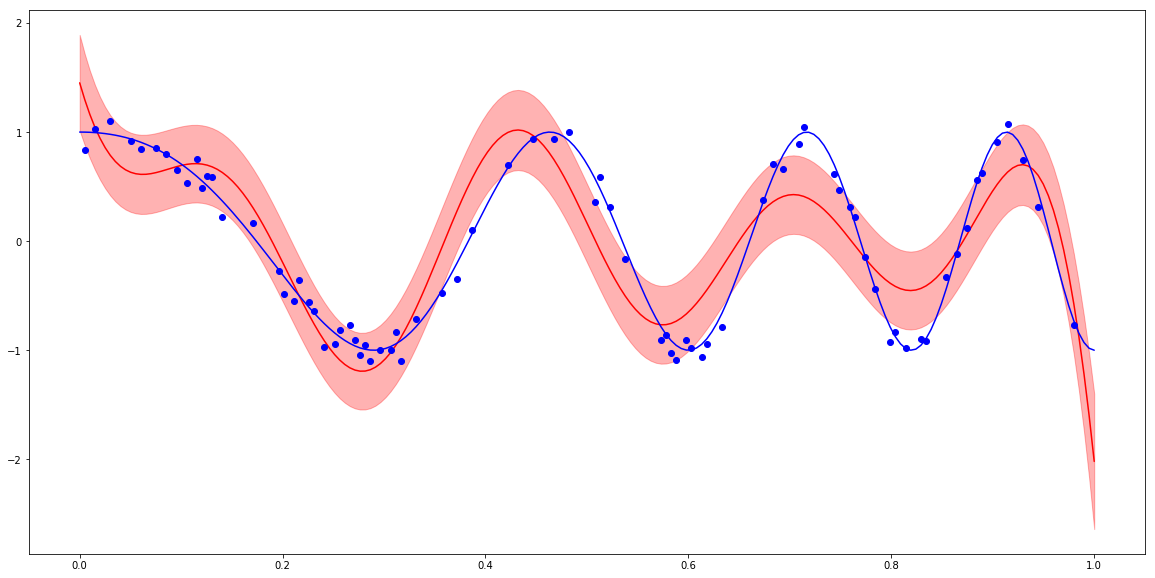

In [439]:
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)
with sns.axes_style("darkgrid"):
    ax.plot(x, tpredicted_bay, 'r')
    ax.plot(X_train, t_train, 'bo')
    ax.plot(x, y, 'b')
    ax.fill_between(x, tpredicted_bay - tpredicted_std, tpredicted_bay + tpredicted_std, alpha=0.3, color='r')